In [1]:
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
from helper import *
import joblib
from sklearn.model_selection import train_test_split
from collections import Counter
from IPython.display import display as dp
from scipy import stats

sns.set_theme(style="darkgrid")
import warnings

warnings.filterwarnings("ignore")

### 📖 EDA Table of Contents

[__1. EDA__](#eda)
- [1.1 Basic overview](#11-basic-overview)
    - [1.1.1 Sample images](#111-sample-images)
    - [1.1.2 File names and file format](#112-file-names-and-file-format)
    - [1.1.3 Image dimension and aspect ratio](#113-image-dimension-and-aspect-ratio)
- [1.2 Target and feature distribution](#12-target-and-feature-distribution)
    - [1.2.1 Target classes distribution](#121-target-classes-distribution)
    - [1.2.2 Race feature distribution](#122-race-feature-distribution)
- [1.3 Color and saturation across target groups](#13-color-and-saturation-across-target-groups)
    - [1.3.1 Brightness and saturation](#131-brightness-and-saturation)
    - [1.3.2 Common color palette](#132-common-color-palette)
- [1.4 Structure and texture detection](#14-structure-and-texture-detection)

[__2. Stratified Data Splitting__](#3-data-splitting)


### 1. EDA

In [2]:
df = joblib.load("data/train_test_data/cleaned_full_df.pkl")
dp(df.head())
print("Dataset Shape:", df.shape)

,file_name,label
0,./data/full_dataset/9_1_2_20161219204347420.jp...,9_1
1,./data/full_dataset/36_0_1_20170117163203851.j...,36_0
2,./data/full_dataset/86_1_0_20170120225751953.j...,86_1
3,./data/full_dataset/26_1_0_20170116171048641.j...,26_1
4,./data/full_dataset/1_1_2_20161219154612988.jp...,1_1


Dataset Shape: (23081, 2)


#### 1.1 Basic overview

##### 1.1.1 Sample images

Sample 80 images to form a basic observation of the dataset.

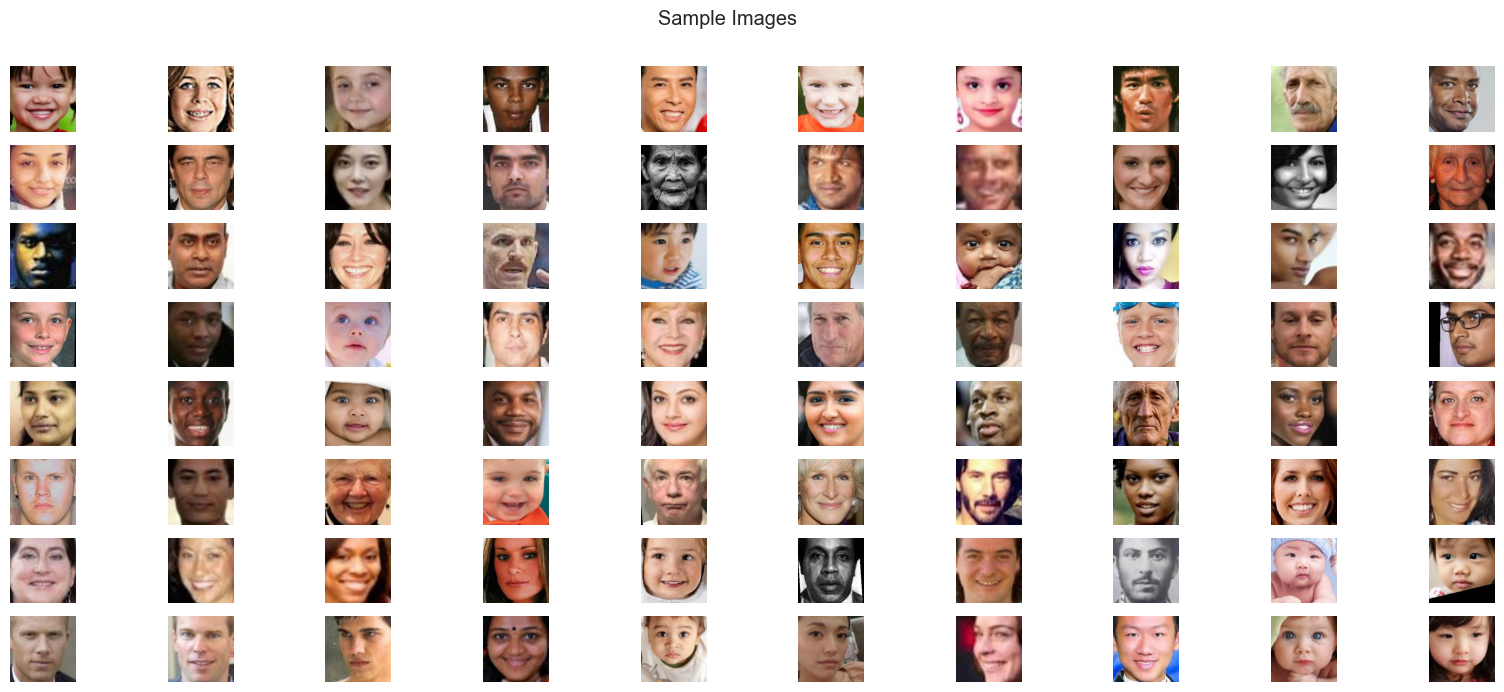

In [3]:
rsample = df.sample(80, random_state=0)
rsample_filename = rsample["file_name"].tolist()

fig_size(20, 8)
for i in rsample_filename:
    with Image.open(i) as img:
        plt.subplot(8, 10, rsample_filename.index(i) + 1)
        plt.imshow(img)
        plt.axis("off")

plt.suptitle("Sample Images", y=0.95)
plt.show()

Here are a few observations based on the samples:

- Most faces are oriented straight ahead, though `some are slightly tilted` to the \
left or right.
- The crop typically extends from the forehead to the chin, with the upper hair \
area often cut off.
- For individuals with `long hair`, the cropped images sometimes show the hair \
forming a darker border around the face.
- A few images seem to be in `black and white`. Are they in greyscale format ?
- The sharpness/ blurriness of the images are different.

Based on the observations, some augmentation for images can help the model to \
learn better:

> horizontal flip

> conversion to grayscale (maybe ?)

##### 1.1.2 File names and file format

In [4]:
filename_ls = df.file_name.tolist()
print("Example file names:\n", filename_ls[:5])

Example file names:
 ['./data/full_dataset/9_1_2_20161219204347420.jpg.chip.jpg', './data/full_dataset/36_0_1_20170117163203851.jpg.chip.jpg', './data/full_dataset/86_1_0_20170120225751953.jpg.chip.jpg', './data/full_dataset/26_1_0_20170116171048641.jpg.chip.jpg', './data/full_dataset/1_1_2_20161219154612988.jpg.chip.jpg']


Do all files end with `jpg.chip.jpg` ?

In [5]:
ends_with_same_format_ls = [bool(i.endswith("jpg.chip.jpg")) for i in filename_ls]


print("Number of files end with same format:", sum(ends_with_same_format_ls))
print("Dataset shape:", df.shape)

Number of files end with same format: 23081
Dataset shape: (23081, 2)


What is the color format of the images ? Is it RGB or RGBA or others ?

In [6]:
img_color_mode_ls = []
for i in filename_ls:
    with Image.open(i) as img:
        color_mode = img.mode
        img_color_mode_ls.append(color_mode)

print(Counter(img_color_mode_ls))

print("All images have the same color mode:", img_color_mode_ls[0])

Counter({'RGB': 23081})
All images have the same color mode: RGB


> All images are of color mode RGB.

> All files are JPEG files which file names end with `jpg.chip.jpg`. 

The double `jpg` endings are likely created during batch processing. \
While `chip` indicates that the preprocessing includes chipping/ cropping the images.

This makes sense, since this dataset is composed of images that are cropped to the face.

Also, all images are of color mode RGB.

##### 1.1.3 Image dimension and aspect ratio

Are the dimension and aspect ratio of the images the same ?

In [7]:
dim_df = pd.DataFrame()
dimension_ls = []
width_ls = []
height_ls = []

for filename in filename_ls:
    with Image.open(filename) as img:
        width_ls.append(img.size[0])
        height_ls.append(img.size[1])
        dimension_ls.append(img.size[0] * img.size[1])

dim_df["dimension (sqpx)"] = dimension_ls
dim_df["width (px)"] = width_ls
dim_df["height (px)"] = height_ls

print("Value Counts of dimensional features:")
dp(dim_df["dimension (sqpx)"].value_counts())
dp(dim_df["width (px)"].value_counts())
dp(dim_df["height (px)"].value_counts())

print(
    f"> All images have the same dimension: \n- {dim_df['dimension (sqpx)'].value_counts().index[0]} squared pixels, \n- {dim_df['width (px)'].value_counts().index[0]}px x {dim_df['height (px)'].value_counts().index[0]}px"
)

Value Counts of dimensional features:


dimension (sqpx)
40000    23081
Name: count, dtype: int64

width (px)
200    23081
Name: count, dtype: int64

height (px)
200    23081
Name: count, dtype: int64

> All images have the same dimension: 
- 40000 squared pixels, 
- 200px x 200px


Since the dataset is composed of preprocessed cropped images, \

> the dimensions of all images are identical:
 
- Width x Height: 200px x 200px


#### 1.2 Target and feature distribution

In [15]:
# prepare plotting dataframe
eda_df = df.copy()

eda_df = eda_df.loc[~df.index.isin([6507, 11831, 16229])].copy()
race_filename_ls = eda_df.file_name.tolist()
race_ls = [i.split("/")[3] for i in race_filename_ls]
race_ls = [i.split("_")[2] for i in race_ls]
eda_df["race"] = race_ls

age = eda_df.label.apply(lambda x: x.split("_")[0]).astype(int)
gender = eda_df.label.apply(
    lambda x: "male" if x.split("_")[1] == "0" else "female"
).astype(str)


gender_ls = ["male", "female"]
age_ls = [
    "pre_school (0~6)",
    "pre-teens (7~13)",
    "teenager (14~17)",
    "young_adult (18~25)",
    "adult (26~40)",
    "middle_age (41~65)",
    "elderly (66~80)",
    "very_elderly (81~120)",
]
race_ls = ["white", "black", "asian", "indian", "hispanic"]

eda_df["gender"] = gender
eda_df["age"] = age

eda_df["age_group"] = pd.cut(
    eda_df.age,
    bins=[0, 7, 14, 18, 26, 41, 66, 81, 120],
    labels=age_ls,
)
eda_df = eda_df.dropna()

race_map = {"0": "white", "1": "black", "2": "asian", "3": "indian", "4": "hispanic"}
eda_df["race_name"] = eda_df.race.apply(lambda i: race_map[i])

##### 1.2.1 Target classes distribution

Inspect the distribution of age and gender individually and the distribution \
of age and gender combined. 

__Important Note__
The decision regarding the binning of age groups is not uniform; it takes into \
account of various life stages, considering both physical and mental development. 

Additionally, it aligns with widely accepted age limits for activities such as \
social media usage, drinking, driving, and retirement, ensuring that the data \
insights are well-suited for practical applications.

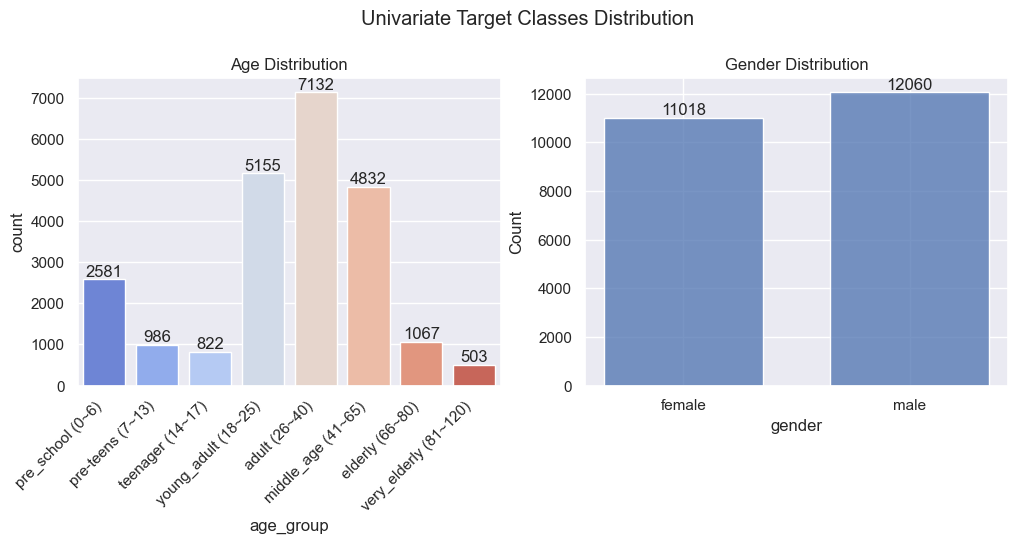

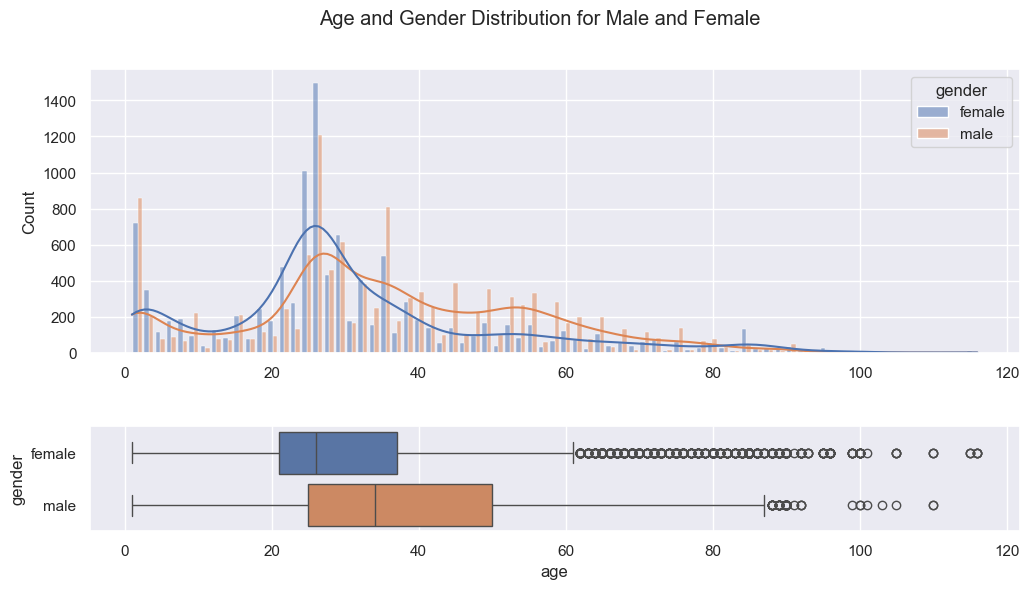

Age Stats:


,Total,Male,Female
count,23078.000000,12060.000000,11018.000000
mean,33.286377,35.705804,30.638138
std,19.872698,19.730219,19.690471
min,1.000000,1.000000,1.000000
25%,23.000000,25.000000,21.000000
50%,29.000000,34.000000,26.000000
75%,45.000000,50.000000,37.000000
max,116.000000,110.000000,116.000000


In [11]:
# univariate
fig_size(12, 4)
plt.subplot(1, 2, 1)
ax = sns.barplot(eda_df.age_group.value_counts(), palette="coolwarm")
plt.xticks(rotation=45, ha="right")
plt.title("Age Distribution")

mark_bar(ax, digit=0)

plt.subplot(1, 2, 2)
ax = sns.histplot(eda_df.gender, shrink=0.7, palette="coolwarm")
plt.title("Gender Distribution")
mark_bar(ax, digit=0)
plt.suptitle("Univariate Target Classes Distribution", y=1.05)
plt.show()

# bivariate
fig = plt.figure(figsize=(12, 6))
gs = GridSpec(3, 1, figure=fig)
ax1 = fig.add_subplot(gs[:2, :])
sns.histplot(
    data=eda_df,
    x="age",
    hue="gender",
    multiple="dodge",
    shrink=0.8,
    kde=True,
    ax=ax1,
)
plt.xlabel("")

ax2 = fig.add_subplot(gs[2, :])
sns.boxplot(x="age", y="gender", data=eda_df, hue="gender", ax=ax2)

plt.subplots_adjust(hspace=0.7)
plt.suptitle("Age and Gender Distribution for Male and Female")

plt.show()


# stats
print("Age Stats:")
total = eda_df.describe()
male = eda_df.query("gender == 'male'").describe()
female = eda_df.query("gender == 'female'").describe()

full = pd.concat([total, male, female], axis=1)
full.columns = ["Total", "Male", "Female"]
full.style.apply(mark_df_color, id=5)

The majority of the age ranges from 23~45.

There's around 10% more male than female in this dataset. And the age distribution \
of male age median is 34 while female 26. \
However, there's more elderly females (> 85) than males.

> Is there a significant difference between the age distribution of males and females ?

Let's verify with a simple T-test:

__H0__: There is no significant difference in age distribution between males and \
females.

__Ha__: There is significant difference in age distribution between males and females. 

alpha = 0.05

In [12]:
male_ages = eda_df.query("gender == 'male'").age.tolist()
female_ages = eda_df.query("gender == 'female'").age.tolist()

t_statistic, p_value = stats.ttest_ind(male_ages, female_ages)

print(f"T-statistic: {t_statistic}")
print(f"P-value: {p_value}")

alpha = 0.05
if p_value < alpha:
    print(
        "\n> Reject the null hypothesis: \nThere is a significant difference in age distribution between males and females."
    )
else:
    print(
        "Fail to reject the null hypothesis: No significant difference in age distribution between males and females."
    )

T-statistic: 19.508315828961287
P-value: 4.441389128365724e-84

> Reject the null hypothesis: 
There is a significant difference in age distribution between males and females.


As there is a significant difference in age distribution of sexes according to \
the t-test, 
> we should stratify the data on both age and gender when preparing \
for train and test set later on. 

> Also apply balancing for the age-gender classes. Play around with different \
balancing methods during modeling (oversampling/ class-balancing)

##### 1.2.2 Race feature distribution

Race information is provided, and races have a strong visual impact on images, \
we would also explore it in more detail.

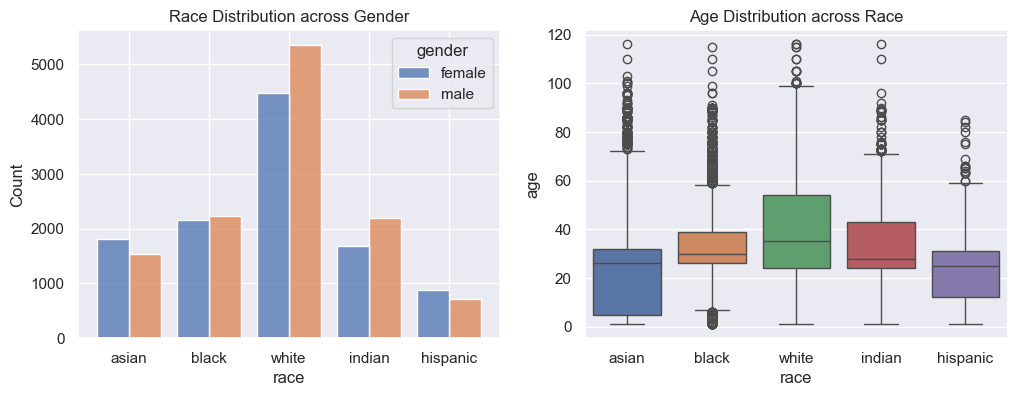

In [13]:
fig_size(12, 4)

plt.subplot(1, 2, 1)
sns.histplot(data=eda_df, x="race", hue="gender", multiple="dodge", shrink=0.8)
plt.xticks([0, 1, 2, 3, 4], ["asian", "black", "white", "indian", "hispanic"])
plt.title("Race Distribution across Gender")
plt.subplot(1, 2, 2)
sns.boxplot(data=eda_df, x="race", y="age", hue="race")
plt.xticks([0, 1, 2, 3, 4], ["asian", "black", "white", "indian", "hispanic"])
plt.title("Age Distribution across Race")

plt.show()

More than 40% of the images are of white race. And the smallest race in this \
dataset is hispanic.

For race black, white, and indian there are more male than female, while for \
asian and hispanic it's the opposite. 

The age median of all races are ranging from 30~35. \
The age distribution of the white race is older than the other races. 


#### 1.3 Color and saturation across target groups

In [12]:
# sample data for efficiency
age_sample_df = (
    eda_df.groupby(
        ["age_group", "gender"],
    )
    .apply(lambda x: x.sample(40, random_state=0))
    .reset_index(drop=True)
)

gender_sample_df = (
    eda_df.groupby(
        "gender",
    )
    .apply(lambda x: x.sample(80, random_state=0))
    .reset_index(drop=True)
)

race_sample_df = (
    eda_df.groupby(
        "race",
    )
    .apply(lambda x: x.sample(40, random_state=0))
    .reset_index(drop=True)
)

##### 1.3.1 Brightness and saturation

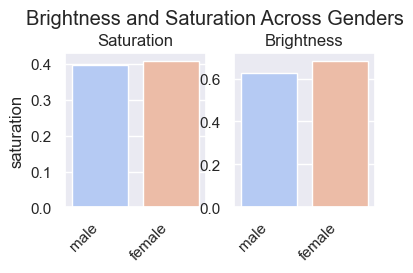

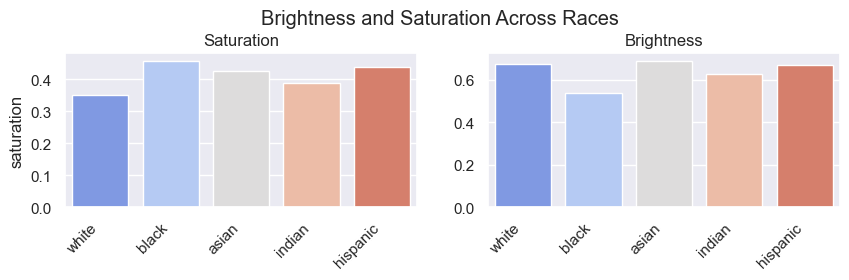

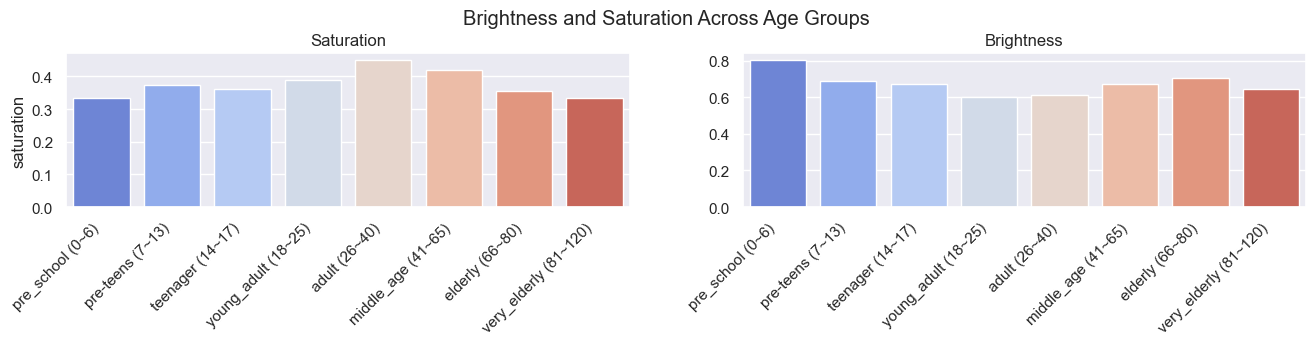

In [31]:
plot_saturation_and_brightness(gender_sample_df, gender_ls, "gender", "Genders")
plot_saturation_and_brightness(race_sample_df, race_ls, "race_name", "Races")
plot_saturation_and_brightness(age_sample_df, age_ls, "age_group", "Age Groups")

Brightness and Saturation

Gender:
- Image saturation is similar between male and female.
- Female images are brighter than male ones.

Race:
- Asian and hispanic race have brighter and more saturated images.
- White race images are brighter but less saturated, black race images are the \
opposite.

Age:
- Preschool kids images are much brighter than other age groups. The biggest \
age population, young_adults and adults have the least bright images.
- The biggest age population (18~65) have the most saturated images, while \
very_elderly and pre_schoolers have the least saturated images.


##### 1.3.2 Common color palette

Use `Kmeans clustering` to identify 10 most common colors and their proportion \
in the feature groups.

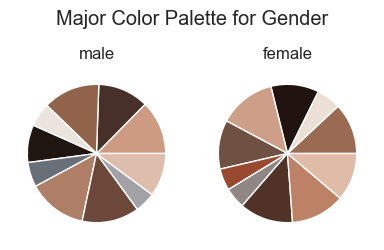

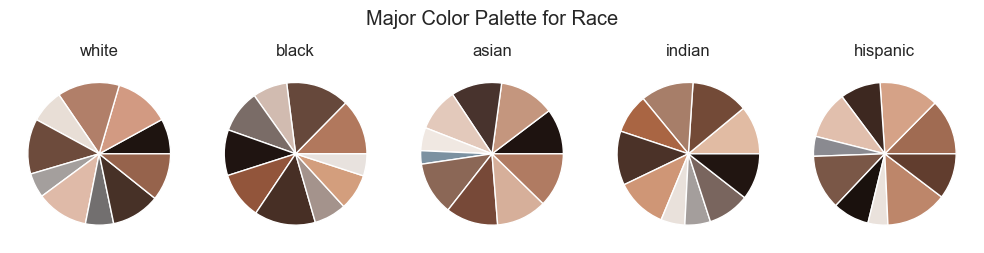

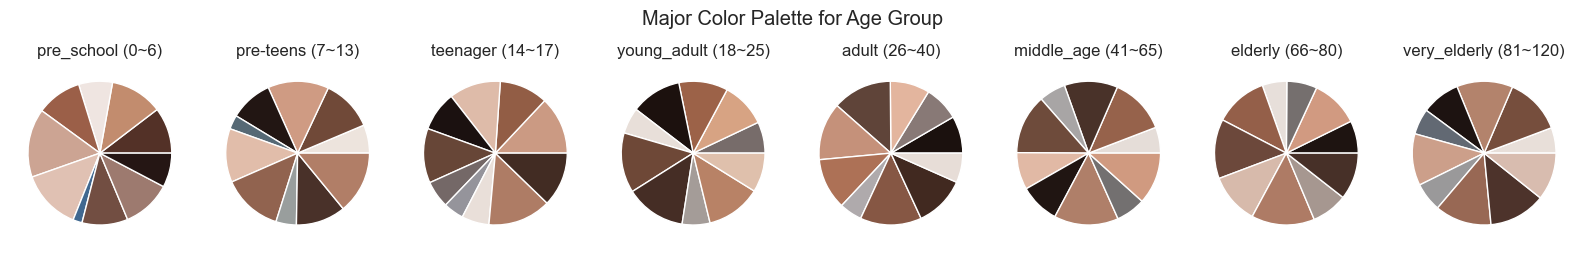

In [32]:
gender_major_colors_dict = get_major_img_colors(eda_df, "gender", gender_ls)
age_major_colors_dict = get_major_img_colors(eda_df, "age_group", age_ls)
race_major_colors_dict = get_major_img_colors(eda_df, "race_name", race_ls)

plot_color_palette(gender_major_colors_dict, "Gender")
plot_color_palette(race_major_colors_dict, "Race")
plot_color_palette(age_major_colors_dict, "Age Group")

The major-color palettes and its color proportion is similar between different \
gender, race, and age groups. 

I was expecting white race to have a paler common color palette and vice versa \
for black race, but this pattern is not observed here.

#### 1.4 Structure and texture detection


Here we use [Canny edge detection](https://docs.opencv.org/4.x/da/d22/tutorial_py_canny.html) from OpenCV. \
The images are the stacking result of 40~80 sample images.


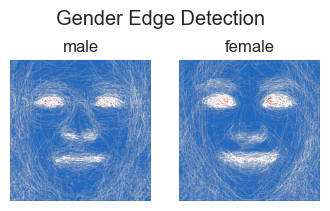

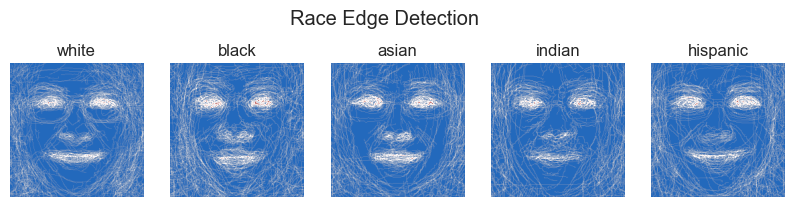

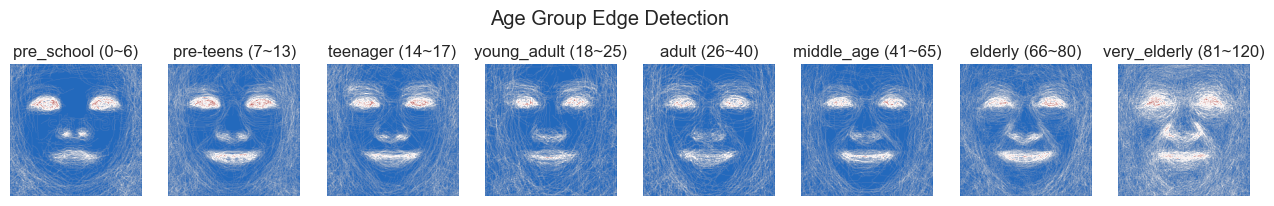

In [41]:
plot_edge_detection(gender_sample_df, gender_ls, "gender", "Gender")
plot_edge_detection(race_sample_df, race_ls, "race_name", "Race")
plot_edge_detection(age_sample_df, age_ls, "age_group", "Age Group")

Observations from the edge detection of different feature groups (averaged img):

Genders:
- Females have narrower face and chin comparing to males.
- The alignment of facial organs are similar between the 2 sexes.

Races:
- Clear glasses can be observed on white race (might be that the majority is middle-age) \
white males. 
- Asian and hispanic races have jaw line that's more square-shaped.
- Black and indian races have longer face shape.

Age Groups:
- Prescholers have higher eyes/face ratio and rounder face shape, the \
overall structure is very distinct from the other age groups. 
- Glasses mark starts to appear after adulthood (26~40).
- Smile lines gradually appear and become prominant from middle_age
- Age group above 66 have significantly more wrinkles.

### 2. Data Splitting
Stratified split by age and gender into train, and val groups. \
The split is: train 70%, val 15%, and test 15%

(Here we also prepare a sample group splitted from the train, which is only used \
for easy visualization and overfitting the model.)

If certain age_gender group has < 3 data points and are thus unsplittable, \
place them in the training set.

In [23]:
# convert labels to tensor
df["label_tensor"] = df["label"].apply(
    lambda i: torch.tensor(np.array(i.split("_"), dtype=np.float32))
)

In [24]:
# unsplittable labels are placed in the train set
rare_labels = df.label.value_counts()[df.label.value_counts() < 3].index.tolist()
# save a copy of the rare labels
rare_label_df = df[df.label.isin(rare_labels)]
# remove the rare labels temporarily
df = df[~df.label.isin(rare_labels)]

print("Unsplittable groups:")
dp(rare_labels)

Unsplittable groups:


['110_0',
 '84_0',
 '100_0',
 '103_0',
 '91_0',
 '101_1',
 '105_0',
 '101_0',
 '99_0',
 '91_1']

In [25]:
train_df, val_df = train_test_split(
    df, test_size=0.15, random_state=0, stratify=df["label"]
)

# sample_df can be used for initial try out and also as sample plots
train_df, test_df = train_test_split(
    train_df, test_size=0.15, random_state=0, stratify=train_df["label"]
)

# add the rare labels to the train
train_df = pd.concat([train_df, rare_label_df])

In [26]:
train_df.shape, val_df.shape, test_df.shape

((16678, 3), (3461, 3), (2942, 3))

In [27]:
joblib.dump(train_df, "data/train_test_data/train_df.pkl")
joblib.dump(val_df, "data/train_test_data/val_df.pkl")
joblib.dump(test_df, "data/train_test_data/test_df.pkl")

['data/train_test_data/test_df.pkl']

The age-gender class distribution should be similar between train and test group. 

As there are 200 age-gender class, below we look at the class distribution proportion \
of the most common 30 classes and the rarest 30 classes.

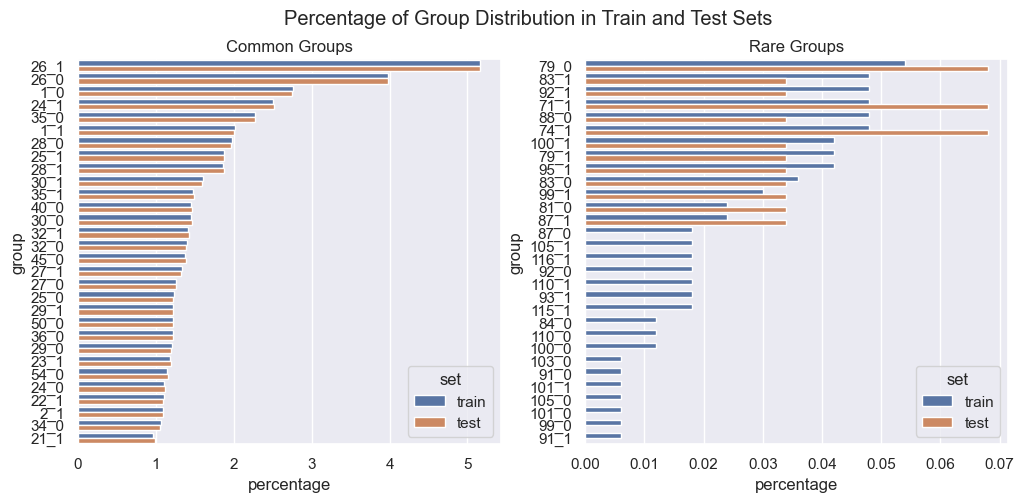

In [28]:
train_counts = (
    train_df.label.value_counts() * 100 / sum(train_df.label.value_counts())
).to_dict()
test_counts = (
    test_df.label.value_counts() * 100 / sum(test_df.label.value_counts())
).to_dict()

split_prop_df = pd.DataFrame([train_counts, test_counts]).T.rename(
    columns={0: "train", 1: "test"}
)

common_groups_df = (
    split_prop_df.head(30)
    .reset_index()
    .melt(id_vars="index", value_vars=["train", "test"])
).rename(columns={"index": "group", "value": "percentage", "variable": "set"})

rare_groups_df = (
    split_prop_df.tail(30)
    .reset_index()
    .melt(id_vars="index", value_vars=["train", "test"])
).rename(columns={"index": "group", "value": "percentage", "variable": "set"})


fig_size(12, 5)
plt.subplot(1, 2, 1)
sns.barplot(data=common_groups_df, y="group", x="percentage", hue="set")
plt.title("Common Groups")

plt.subplot(1, 2, 2)
sns.barplot(data=rare_groups_df, y="group", x="percentage", hue="set")
plt.title("Rare Groups")

plt.suptitle(
    "Percentage of Group Distribution in Train and Test Sets",
)

plt.show()

The distribution of the both groups are similar between train and test set in \
common age-gender groups. 

The distribution of the rare groups has higher percentage in test group because \
the rare cases are sometimes evenly splitted due to small numbers (not following \
70-30 split).

Some classes are missing in test set in the rare groups, as the number of data point \
is too little to be splitted. 

💡 This is the end of data EDA, continue to modeling in `3_modeling.ipynb`